In [9]:
#!pip install -r .\requirements.txt
#!pip freeze | findstr /V /C:"-e" /C:"file:" /C:"@" > requirements.txt


In [1]:
# This paper used to impeliment following script: Evaluation of time stability and uniqueness in PPG-based biometric systems
# Impelimentation by Danyal Shahmirzadi, Yuntech . Oct 2023

import neurokit2 as nk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import scipy.io
from scipy.signal import find_peaks
import warnings
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import skew
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#from scipy.integrate import trapz
from numpy import trapz

import pywt
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import copy
from fastdtw import fastdtw
from scipy.interpolate import interp1d
from tslearn.metrics import dtw_path
import time


warnings.filterwarnings('ignore')

In [2]:
#Scal a signal to a fixed length 
def scale_signal(signal, target_length):
    # Create an interpolation function
    interp_func = interp1d(np.linspace(0, 1, len(signal)), signal, kind='linear', fill_value="extrapolate")

    # Generate new indices for the scaled signal
    scaled_indices = np.linspace(0, 1, target_length)

    # Use the interpolation function to obtain the scaled signal
    scaled_signal = interp_func(scaled_indices)

    return scaled_signal

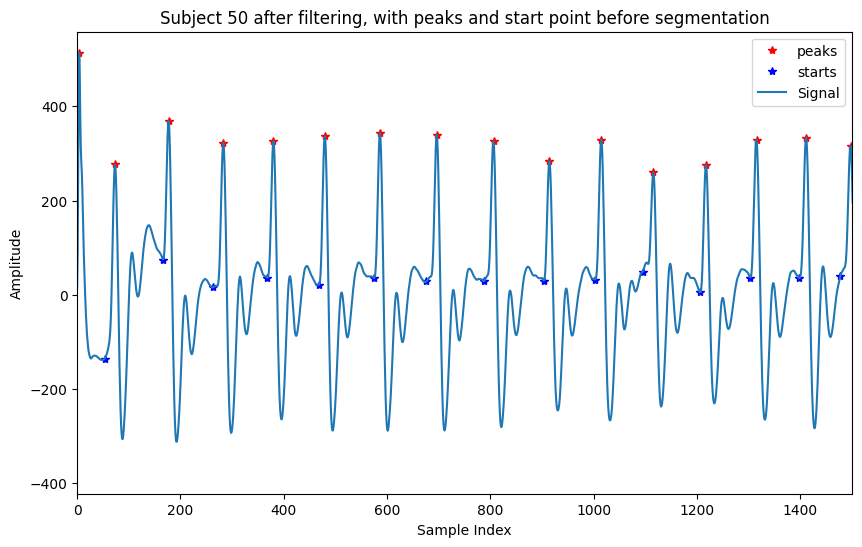

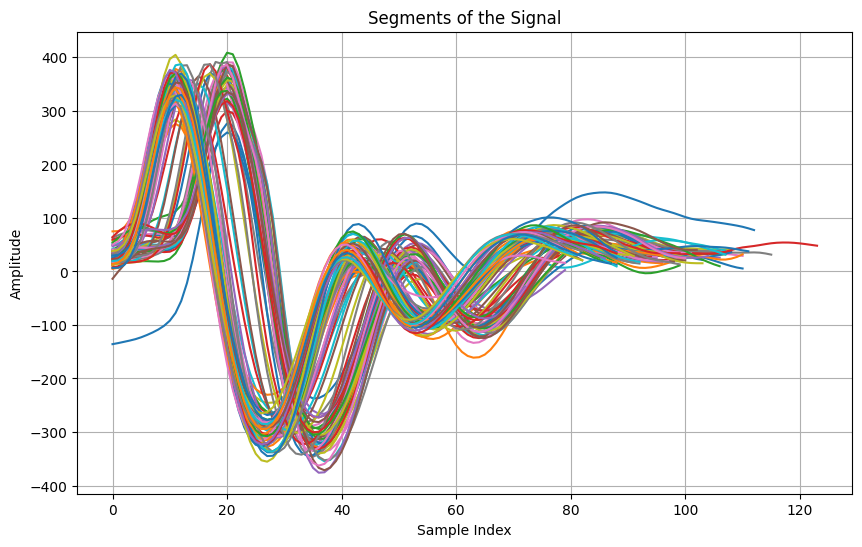

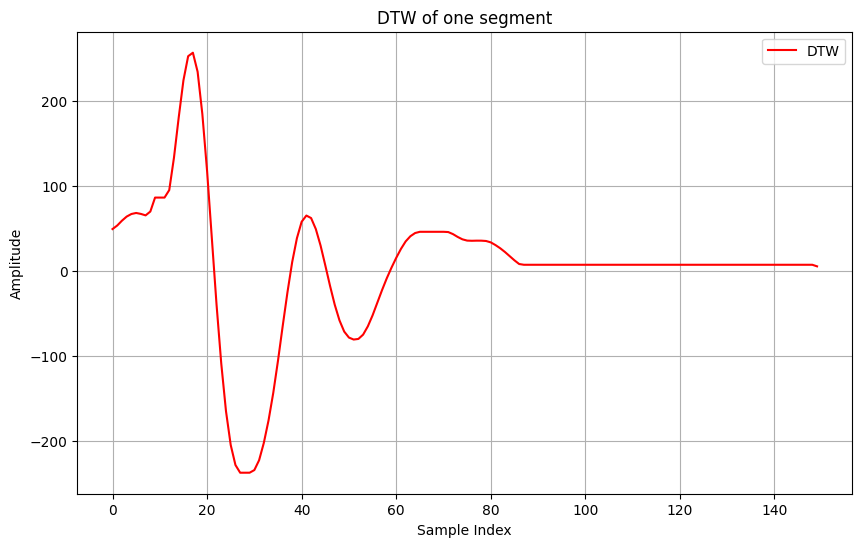

In [4]:
# Load the dataset. This database is available on demand from university of toronto 
mat_file = scipy.io.loadmat('./Biosec2_raw_data.mat')
signal = mat_file['Data_cell']

# Apply a 4th order Butterworth bandpass filter [0.5 18]hz 
low_cutoff_freq = 0.5 # Cutoff frequency for low-pass filter in Hz
high_cutoff_freq = 18 # Cutoff frequency for high-pass filter in Hz
sampling_rate = 100 # Sampling rate is the number of samples per second
nyquist_freq = 0.5 * sampling_rate
low_normal_cutoff = low_cutoff_freq / nyquist_freq
high_normal_cutoff = high_cutoff_freq / nyquist_freq

# define a function that takes the session (there are 2 sessions) ..
# and trial (there are 3 trials in each sessions) then returns the features 
def extraxtfeatures(trial, session):
    peaks=[]
    starts= []
    filtered_signals = []
    rr_intervals = []
    for i in range(100):
        # Generate filter coefficients
        # Apply the filter to the signal
        b, a = butter(4, [low_normal_cutoff, high_normal_cutoff], btype='band')
        #reshape the signal 
        s = signal[i, trial, session]
        slen = len(s[0])
        s = np.reshape(s, slen)
        signal[i, trial, session] = s
        #Filter the signal 
        filtered_signal = lfilter(b, a, s)
        #normalize signal between 0 and 1 
        #min_value = np.min(filtered_signal)
        #max_value = np.max(filtered_signal)
        #filtered_signal = (filtered_signal - min_value) / (max_value - min_value)
        filtered_signals.append(filtered_signal)
        #find the signal peaks
        peak, _ = find_peaks(filtered_signal, height=0.2, distance=50)  # Adjust parameters as needed
        
        # # Compute RR intervals
        rr_interval = np.diff(peak)
        rr_intervals.append(rr_interval)
        
        # if the rr interval is 20% higher or 60% lower than the average, the signal between 2 peaks will be ignored 
        lenght = len(peak)-1
        hit=[]
        new_peak=peak
        for j in range (lenght):
            if j < len(peak-1):
                if (peak[j+1] - peak[j] > 1.2 * np.mean(rr_interval) or peak[j+1] - peak[j] < 0.6 * np.mean(rr_interval)):
                    #print("yes" , i , j)
                    hit.append(j)
        new_peak = np.delete(peak,hit)
        peaks.append(new_peak)
        
        # Find the start pint of each pulse : the minimum in Peak previous 20 samples 
        start=[]
        for j in  (new_peak):
            if j > 20:
                start.append(j - 20 + np.argmin(filtered_signal[j-20:j]))
        starts.append(start)
    X = peaks
    return X , filtered_signals , starts

peak , filtered_signals , starts = extraxtfeatures(2,0)


# This function will segmetize all 100 signals in filtered_signals to seperate cardiac cycles 
def segmentize(starts, filtered_signals):
    segments_list = [[] for _ in range(100)]

    for i in range(100):
        for j in range(len(starts[i])-1):
            if ((starts[i][j+1] - starts[i][j]) < 150 ):
                current_segment = filtered_signals[i][starts[i][j]: starts[i][j+1]]
            segments_list[i].append(current_segment)
    return segments_list

segments_list = segmentize(starts,filtered_signals)

def apply_dtw(segments):
    dwt_list =  [[] for _ in range(100)]
    #have a copy segments in dtw, so we won't change segments itself (We must use deepcopy)
    dtw=copy.deepcopy(segments)
    # Initialize an empty list to store DWT coefficients for each signal
    dwt_coefficients_list = [[] for _ in range(100)]
    # Wavelet function and level of decomposition
    wavelet = 'db4'
    level = 1  # Choose the level of decomposition based on your requirements
    # Target length for each segment
    target_length = 150
    # Iterate through each signal
    for i in range(100):
        # Iterate through each start location for the current signal
        for j in range(len(segments[i])):
            # Extract the segment from the current signal
            current_segment = np.array(segments[i][j])  # Convert to NumPy array
            # Apply Discrete Wavelet Transform
            coefficients = []
            coefficients = pywt.wavedec(current_segment, wavelet , level=level)
            cA = coefficients[0]
            cD = coefficients[1]
            try:
                dwt_signal = pywt.waverec([cA, None] + [None] * (len(coefficients) -2) , wavelet)
                cD = cD + cA[-1]
                dtw[i][j] = np.concatenate([cA , cD])
                # To calculate DB4 of signal we use cA + cD (both In level one DB4) but cA is amplified by the last elemnt of cA
                desired_length = 150
                padding_value = cD[-1]
                #we mostly need to extend DB4 result, instead for segment 35 in signal 10 which DB4 has the length of 156 and we need to scale it to 150.
                if (len(dtw[i][j]) > 150):
                    dtw[i][j] = scale_signal (dtw[i][j] , 150)
                else:
                    num_elements_to_add = desired_length - len(dtw[i][j])
                    dtw[i][j] = np.pad(dtw[i][j], (0, num_elements_to_add), constant_values=padding_value)
                
                # Calculate the DTW path of our original puls with its DB4 (dtw[i][j]) as reference 
                temp, _ = dtw_path(segments[i][j],dtw[i][j])
                x_path, y_path = zip(*temp)
                x_path = np.asarray(x_path)
                #y_path = np.asarray(y_path)
                x_warped = segments[i][j][x_path]
                #y_warped = signal2[y_path]
                dtw[i][j] = scale_signal(x_warped, target_length=150)
            except ValueError as e:
                print(f"Error for segment {j} in signal {i}: {e}")
    return dtw
        
#Plot signal 50 
plt.figure(figsize=(10, 6))
plt.title('Subject 50 after filtering, with peaks and start point before segmentation')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.plot(peak[50],filtered_signals[50][peak[50]],'r*' ,label='peaks')
plt.plot(starts[50],filtered_signals[50][starts[50]],'b*' ,label='starts')
plt.plot(filtered_signals[50] ,label='Signal')
plt.xlim(0,1500)
plt.legend()

# Create a new plot and show all segments
plt.figure(figsize=(10, 6))
plt.title('Segments of the Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
for i, segment in enumerate(segments_list[50]):
    plt.plot(range(len(segment)), segment)
plt.grid()
plt.show()

#Calculate DTW
dtw=copy.deepcopy(segments_list)
dtw = apply_dtw (dtw)


# Create a new plot and show DTW segmnents
plt.figure(figsize=(10, 6))
plt.title('DTW of one segment')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.plot(dtw[50][10],'-r' ,label='DTW') 
#plt.plot(segments_list[50][10],'-b' ,label='Signal') 
plt.grid()
plt.legend()
plt.show()



In [5]:
# Time benchmark (Reviewers asked)
runtimes = []
for i in range(100):
    
    b, a = butter(4, [low_normal_cutoff, high_normal_cutoff], btype='band')
    #reshape the signal 
    s = signal[i, 2, 0]
    
    start_time = time.time()
    #Filter the signal 
    filtered_signal = lfilter(b, a, s)
    end_time = time.time()
    runtimes.append(end_time - start_time)

# Report average runtime
average_time = np.mean(runtimes)
print(f"Average runtime per signal for extraxtfeatures(2, i): {average_time:.4f} seconds")

start_time = time.time()
segments_list = segmentize(starts, filtered_signals)
segmentation_time = time.time() - start_time

start_time = time.time()
dtw = apply_dtw(segments_list)
dtw_time = time.time() - start_time


print(f"Average runtime per signal for segmentation(2, i): {segmentation_time:.5f} seconds")
print(f"Average runtime per signal for dtw_time(2, i): {dtw_time:.4f} seconds")


Average runtime per signal for extraxtfeatures(2, i): 0.0000 seconds
Average runtime per signal for segmentation(2, i): 0.01481 seconds
Average runtime per signal for dtw_time(2, i): 2.0244 seconds


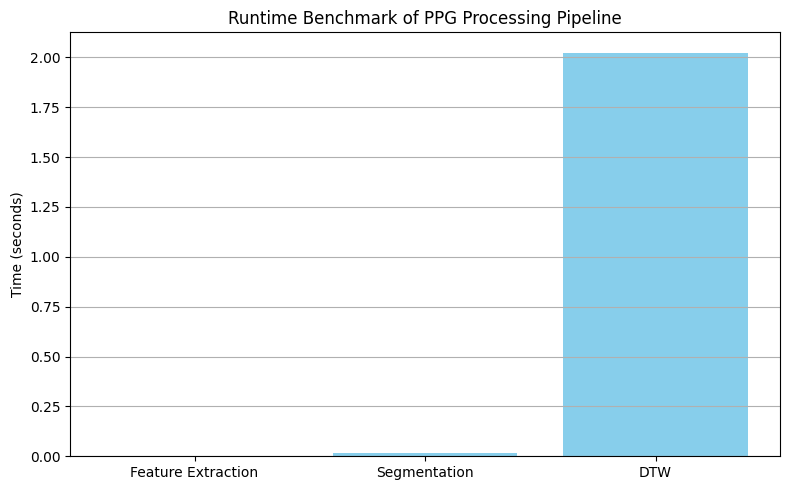

In [6]:
# Labels and values
steps = ['Feature Extraction', 'Segmentation', 'DTW']
times = [average_time, segmentation_time, dtw_time]

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(steps, times, color='skyblue')
plt.ylabel('Time (seconds)')
plt.title('Runtime Benchmark of PPG Processing Pipeline')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

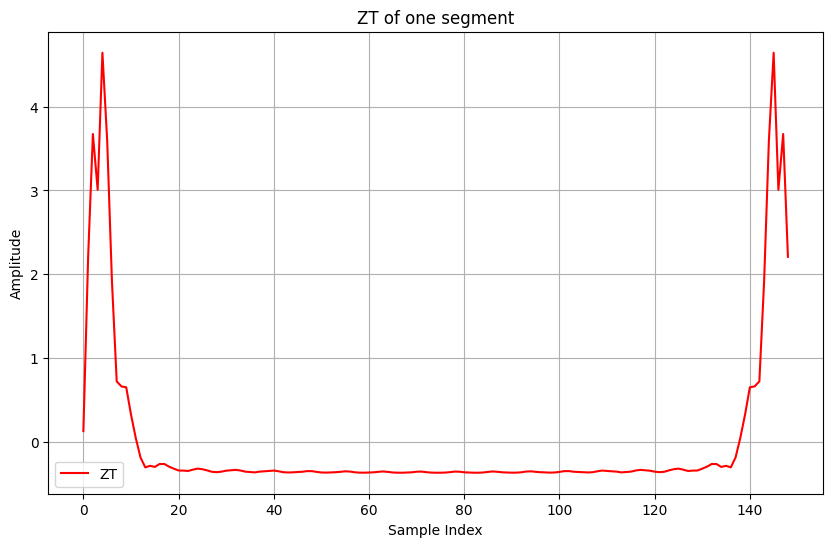

In [7]:
#ZT input implementation (Zero padding in time)
def apply_zt(segments):
    zt_list =  [[] for _ in range(100)]
    #have a copy segments in zt, so we won't change segments itself (We must use deepcopy)
    zt=copy.deepcopy(segments)
    for i in range(100):
    # Iterate through each start location for the current signal
        for j in range(len(segments[i])):
            # Extract the segment from the current signal
            current_segment = np.array(segments[i][j])  # Convert to NumPy array
            peak_index = np.argmax(current_segment)
            zeros_to_add = 150 - len(current_segment)
            zt[i][j] = np.concatenate([current_segment[peak_index:], np.zeros(zeros_to_add), current_segment[:peak_index-1]])
            # Calculate the FFT
            fft_result = np.fft.fft(zt[i][j])
            # Calculate the magnitude (power spectrum)
            zt[i][j] = np.abs(fft_result)
            #standardize it
            zt[i][j] = (zt[i][j] - np.mean(zt[i][j] )) / np.std(zt[i][j])
    return zt
    
#Calculate DTW
zt=copy.deepcopy(segments_list)
zt = apply_zt(zt)

# Create a new plot and show DTW segmnents
plt.figure(figsize=(10, 6))
plt.title('ZT of one segment')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.plot(zt[50][10],'-r' ,label='ZT')
#for i, segment in enumerate(zt[50]):
#        plt.plot(range(len(segment)), segment)
#plt.plot(segments_list[50][10],'-b' ,label='Signal') 
plt.grid()
plt.legend()
plt.show()

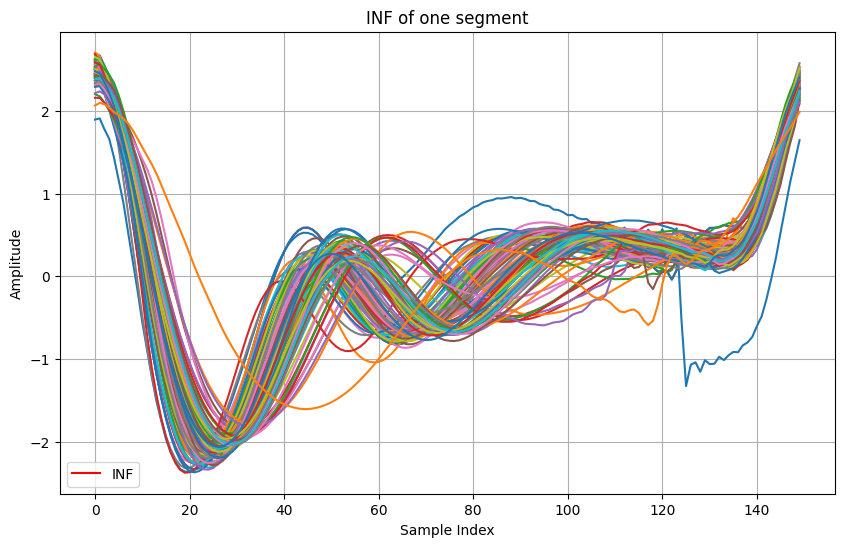

In [9]:
#Interpolation in frequency implementation 
def apply_inf(segments):
    inf_list =  [[] for _ in range(100)]
    #have a copy segments in zt, so we won't change segments itself (We must use deepcopy)
    inf=copy.deepcopy(segments)
    for i in range(100):
    # Iterate through each start location for the current signal
        for j in range(len(segments[i])):
            # Extract the segment from the current signal
            current_segment = np.array(segments[i][j])  # Convert to NumPy array
            peak_index = np.argmax(current_segment)
            inf[i][j] = np.concatenate([current_segment[peak_index:], current_segment[:peak_index-1]])
            # Calculate the FFT
            fft_result = np.fft.fft(inf[i][j])
            # Calculate the magnitude (power spectrum)
            magnitude = np.abs(fft_result)
            #inf[i][j] = magnitude
            zeros_to_add = 150 - len(magnitude)
            magnitude = np.concatenate([magnitude[:len(magnitude)//2], np.zeros(zeros_to_add), magnitude[len(magnitude)//2:]])
            # Calculate the phase (angle) spectrum
            angle = np.angle(fft_result)
            zeros_to_add = 150 - len(angle)
            angle = np.concatenate([angle[:len(angle)//2], np.zeros(zeros_to_add), angle[len(angle)//2:]])
            # use this formula (3)
            result = magnitude * np.exp(1j * angle)
            # calculate inverse FFT
            inf[i][j] = np.fft.ifft(result)
            #standardize it
            inf[i][j] = (inf[i][j] - np.mean(inf[i][j] )) / np.std(inf[i][j])
    return inf
#Calculate DTW
inf=copy.deepcopy(segments_list)
inf = apply_inf(inf)

# Create a new plot and show DTW segmnents
plt.figure(figsize=(10, 6))
plt.title('INF of one segment')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.plot(inf[50][10],'-r' ,label='INF') 
for i, segment in enumerate(inf[50]):
        plt.plot(range(len(segment)), segment)
plt.grid()
plt.legend()
plt.show()

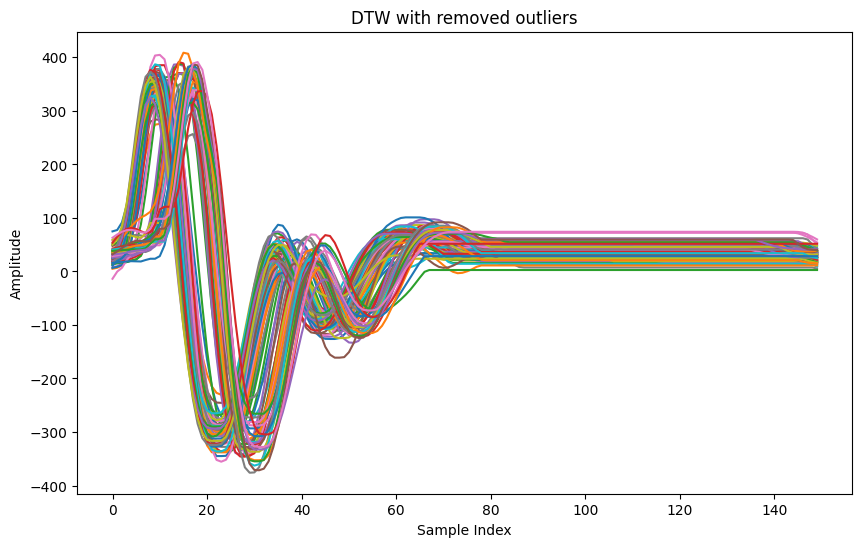

In [11]:
#Commit test by MAC
#Remove outliers

# Function to calculate Euclidean distance between two signals
def euclidean_distance(signal1, signal2):
    return np.linalg.norm(signal1 - signal2)

def remove_outliers(signal):
    average_signal =  [[] for _ in range(100)]
    rm=copy.deepcopy(signal)
    for i in range(100):
        stacked = np.stack(rm [i], axis =1)
        average_signal[i]=(np.mean(stacked,axis = 1))
        
    for i, signal in enumerate(rm):
        distances = [euclidean_distance(segment, average_signal[i]) for segment in signal]
        sorted_indices = np.argsort(distances)
        rm[i] = ([signal[j] for j in sorted_indices[0:-5]]) #remove 5 latest segments which have highest EC distance
    return rm

dtw_rmo = remove_outliers(dtw) #DTW with removed outliers (5)
zt_rmo = remove_outliers(zt)   #ZT with removed outliers (5)
inf_rmo = remove_outliers(inf) #INF with removed outliers (5)

#plot DTW with removed outliers
plt.figure(figsize=(10, 6))
plt.title('DTW with removed outliers')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
for i, segment in enumerate(dtw_rmo[50]):
        plt.plot(range(len(segment)), segment)


In [12]:
from itertools import chain

X = dtw_rmo
X = [item for sublist in X for item in sublist]

lengths = [len(inner_list) for inner_list in zt_rmo]
y = [[idx] * length for idx, length in enumerate(lengths)]
y = list(chain.from_iterable(y))
#[len(inner_list) for inner_list in X_train] calculate length of nested list 

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
from mealpy import GA  # Import from the correct subpackage
from mealpy import IntegerVar, FloatVar
from sklearn.metrics import r2_score
import xgboost as xgb



def objective_function(params_list):  # Rename to avoid confusion
    params_dict = dict(zip(params.keys(), params_list))  # Create dictionary from values
    model = xgb.XGBClassifier(max_depth=int(params_list[0]), n_estimators= int(params_list[1]), 
                             base_score=float(params_list[2]),tree_method='gpu_hist', gpu_id=0)  # Unpack dictionary
    model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)])
    y_pred = model.predict(X_test)
    y_pred=np.round(y_pred)
    
    #return -model.score(X_validation, y_validation)
    return accuracy_score(y_pred, y_test)
params = {
    "obj_func": objective_function,
    "bounds": [IntegerVar(lb=[1], ub=[20],name='max_depth' ), IntegerVar(lb=[10], ub=[150],name='n_estimators' ),
               FloatVar(lb=[0.001], ub=[0.8],name='base_score' ),],
    "minmax": "max",
}

optimizer = GA.BaseGA(epoch=5, pop_size=10, pc=0.85, pm=0.1)
optimizer.solve(params)

print(optimizer.g_best.solution)
print(optimizer.g_best.target.fitness)

2025/06/19 08:50:43 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: BaseGA(epoch=5, pop_size=10, pc=0.85, pm=0.1)


[0]	validation_0-mlogloss:1.92708	validation_1-mlogloss:2.53140
[1]	validation_0-mlogloss:1.39996	validation_1-mlogloss:2.21456
[2]	validation_0-mlogloss:1.08365	validation_1-mlogloss:2.02371
[3]	validation_0-mlogloss:0.86198	validation_1-mlogloss:1.89882
[4]	validation_0-mlogloss:0.69782	validation_1-mlogloss:1.80374
[5]	validation_0-mlogloss:0.57252	validation_1-mlogloss:1.72004
[6]	validation_0-mlogloss:0.47398	validation_1-mlogloss:1.65806
[7]	validation_0-mlogloss:0.39759	validation_1-mlogloss:1.60632
[8]	validation_0-mlogloss:0.33409	validation_1-mlogloss:1.56198
[9]	validation_0-mlogloss:0.28345	validation_1-mlogloss:1.52370
[10]	validation_0-mlogloss:0.24035	validation_1-mlogloss:1.49142
[11]	validation_0-mlogloss:0.20561	validation_1-mlogloss:1.45970
[12]	validation_0-mlogloss:0.17700	validation_1-mlogloss:1.43693
[13]	validation_0-mlogloss:0.15353	validation_1-mlogloss:1.41704
[14]	validation_0-mlogloss:0.13395	validation_1-mlogloss:1.39747
[15]	validation_0-mlogloss:0.11692	

2025/06/19 08:54:16 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 0.716696269982238, Global best: 0.716696269982238, Runtime: 114.71491 seconds


[0]	validation_0-mlogloss:1.92523	validation_1-mlogloss:2.53386
[1]	validation_0-mlogloss:1.38741	validation_1-mlogloss:2.21325
[2]	validation_0-mlogloss:1.05878	validation_1-mlogloss:2.01848
[3]	validation_0-mlogloss:0.83379	validation_1-mlogloss:1.89264
[4]	validation_0-mlogloss:0.66791	validation_1-mlogloss:1.79705
[5]	validation_0-mlogloss:0.54063	validation_1-mlogloss:1.71654
[6]	validation_0-mlogloss:0.44341	validation_1-mlogloss:1.65169
[7]	validation_0-mlogloss:0.36774	validation_1-mlogloss:1.59730
[8]	validation_0-mlogloss:0.30681	validation_1-mlogloss:1.55259
[9]	validation_0-mlogloss:0.25755	validation_1-mlogloss:1.51255
[10]	validation_0-mlogloss:0.21719	validation_1-mlogloss:1.47883
[11]	validation_0-mlogloss:0.18510	validation_1-mlogloss:1.44951
[12]	validation_0-mlogloss:0.15859	validation_1-mlogloss:1.42546
[13]	validation_0-mlogloss:0.13663	validation_1-mlogloss:1.40406
[14]	validation_0-mlogloss:0.11886	validation_1-mlogloss:1.38396
[15]	validation_0-mlogloss:0.10399	

2025/06/19 08:56:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 0.7220248667850799, Global best: 0.7220248667850799, Runtime: 138.31813 seconds


[0]	validation_0-mlogloss:1.92507	validation_1-mlogloss:2.53410
[1]	validation_0-mlogloss:1.38144	validation_1-mlogloss:2.21449
[2]	validation_0-mlogloss:1.04187	validation_1-mlogloss:2.02011
[3]	validation_0-mlogloss:0.80662	validation_1-mlogloss:1.89735
[4]	validation_0-mlogloss:0.63528	validation_1-mlogloss:1.80425
[5]	validation_0-mlogloss:0.50668	validation_1-mlogloss:1.72600
[6]	validation_0-mlogloss:0.40826	validation_1-mlogloss:1.65976
[7]	validation_0-mlogloss:0.33209	validation_1-mlogloss:1.60479
[8]	validation_0-mlogloss:0.27253	validation_1-mlogloss:1.55817
[9]	validation_0-mlogloss:0.22565	validation_1-mlogloss:1.51917
[10]	validation_0-mlogloss:0.18888	validation_1-mlogloss:1.48530
[11]	validation_0-mlogloss:0.15934	validation_1-mlogloss:1.45506
[12]	validation_0-mlogloss:0.13594	validation_1-mlogloss:1.42993
[13]	validation_0-mlogloss:0.11693	validation_1-mlogloss:1.40663
[14]	validation_0-mlogloss:0.10156	validation_1-mlogloss:1.38814
[15]	validation_0-mlogloss:0.08893	

2025/06/19 08:59:17 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 0.7220248667850799, Global best: 0.7220248667850799, Runtime: 162.58034 seconds


[0]	validation_0-mlogloss:1.92523	validation_1-mlogloss:2.53386
[1]	validation_0-mlogloss:1.38741	validation_1-mlogloss:2.21325
[2]	validation_0-mlogloss:1.05878	validation_1-mlogloss:2.01848
[3]	validation_0-mlogloss:0.83379	validation_1-mlogloss:1.89264
[4]	validation_0-mlogloss:0.66791	validation_1-mlogloss:1.79705
[5]	validation_0-mlogloss:0.54063	validation_1-mlogloss:1.71654
[6]	validation_0-mlogloss:0.44341	validation_1-mlogloss:1.65169
[7]	validation_0-mlogloss:0.36774	validation_1-mlogloss:1.59730
[8]	validation_0-mlogloss:0.30681	validation_1-mlogloss:1.55259
[9]	validation_0-mlogloss:0.25755	validation_1-mlogloss:1.51255
[10]	validation_0-mlogloss:0.21719	validation_1-mlogloss:1.47883
[11]	validation_0-mlogloss:0.18510	validation_1-mlogloss:1.44951
[12]	validation_0-mlogloss:0.15859	validation_1-mlogloss:1.42546
[13]	validation_0-mlogloss:0.13663	validation_1-mlogloss:1.40406
[14]	validation_0-mlogloss:0.11886	validation_1-mlogloss:1.38396
[15]	validation_0-mlogloss:0.10399	

2025/06/19 09:01:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 0.7335701598579041, Global best: 0.7335701598579041, Runtime: 148.03025 seconds


[0]	validation_0-mlogloss:1.92523	validation_1-mlogloss:2.53386
[1]	validation_0-mlogloss:1.38741	validation_1-mlogloss:2.21325
[2]	validation_0-mlogloss:1.05878	validation_1-mlogloss:2.01848
[3]	validation_0-mlogloss:0.83379	validation_1-mlogloss:1.89264
[4]	validation_0-mlogloss:0.66791	validation_1-mlogloss:1.79705
[5]	validation_0-mlogloss:0.54063	validation_1-mlogloss:1.71654
[6]	validation_0-mlogloss:0.44341	validation_1-mlogloss:1.65169
[7]	validation_0-mlogloss:0.36774	validation_1-mlogloss:1.59730
[8]	validation_0-mlogloss:0.30681	validation_1-mlogloss:1.55259
[9]	validation_0-mlogloss:0.25755	validation_1-mlogloss:1.51255
[10]	validation_0-mlogloss:0.21719	validation_1-mlogloss:1.47883
[11]	validation_0-mlogloss:0.18510	validation_1-mlogloss:1.44951
[12]	validation_0-mlogloss:0.15859	validation_1-mlogloss:1.42546
[13]	validation_0-mlogloss:0.13663	validation_1-mlogloss:1.40406
[14]	validation_0-mlogloss:0.11886	validation_1-mlogloss:1.38396
[15]	validation_0-mlogloss:0.10399	

2025/06/19 09:04:29 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 0.7335701598579041, Global best: 0.7335701598579041, Runtime: 164.40429 seconds


[  2.         146.           0.78557578]
0.7335701598579041


[111]	validation_0-mlogloss:0.00896	validation_1-mlogloss:1.27018
[112]	validation_0-mlogloss:0.00892	validation_1-mlogloss:1.27028
[113]	validation_0-mlogloss:0.00888	validation_1-mlogloss:1.27047
[114]	validation_0-mlogloss:0.00885	validation_1-mlogloss:1.27026
[115]	validation_0-mlogloss:0.00881	validation_1-mlogloss:1.27052
[116]	validation_0-mlogloss:0.00877	validation_1-mlogloss:1.27023
[117]	validation_0-mlogloss:0.00874	validation_1-mlogloss:1.27023
[118]	validation_0-mlogloss:0.00871	validation_1-mlogloss:1.27002
[119]	validation_0-mlogloss:0.00867	validation_1-mlogloss:1.27040
[120]	validation_0-mlogloss:0.00864	validation_1-mlogloss:1.26983
[121]	validation_0-mlogloss:0.00861	validation_1-mlogloss:1.26993
[122]	validation_0-mlogloss:0.00858	validation_1-mlogloss:1.26998
[123]	validation_0-mlogloss:0.00855	validation_1-mlogloss:1.26970
[124]	validation_0-mlogloss:0.00852	validation_1-mlogloss:1.26977
[125]	validation_0-mlogloss:0.00849	validation_1-mlogloss:1.27006
[126]	vali

[95]	validation_0-mlogloss:0.01199	validation_1-mlogloss:1.18678
[96]	validation_0-mlogloss:0.01187	validation_1-mlogloss:1.18729
[97]	validation_0-mlogloss:0.01177	validation_1-mlogloss:1.18732
[98]	validation_0-mlogloss:0.01167	validation_1-mlogloss:1.18733
[0]	validation_0-mlogloss:2.05608	validation_1-mlogloss:2.65615
[1]	validation_0-mlogloss:1.43738	validation_1-mlogloss:2.31876
[2]	validation_0-mlogloss:1.06483	validation_1-mlogloss:2.14287
[3]	validation_0-mlogloss:0.81023	validation_1-mlogloss:2.02742
[4]	validation_0-mlogloss:0.63130	validation_1-mlogloss:1.93507
[5]	validation_0-mlogloss:0.49713	validation_1-mlogloss:1.85838
[6]	validation_0-mlogloss:0.39766	validation_1-mlogloss:1.79376
[7]	validation_0-mlogloss:0.32110	validation_1-mlogloss:1.73886
[8]	validation_0-mlogloss:0.26191	validation_1-mlogloss:1.68693
[9]	validation_0-mlogloss:0.21583	validation_1-mlogloss:1.64393
[10]	validation_0-mlogloss:0.17945	validation_1-mlogloss:1.61058
[11]	validation_0-mlogloss:0.15086	

[8]	validation_0-mlogloss:0.28468	validation_1-mlogloss:1.67125
[9]	validation_0-mlogloss:0.23546	validation_1-mlogloss:1.62923
[10]	validation_0-mlogloss:0.19648	validation_1-mlogloss:1.59565
[11]	validation_0-mlogloss:0.16537	validation_1-mlogloss:1.56287
[12]	validation_0-mlogloss:0.14071	validation_1-mlogloss:1.53594
[13]	validation_0-mlogloss:0.12033	validation_1-mlogloss:1.51030
[14]	validation_0-mlogloss:0.10403	validation_1-mlogloss:1.48924
[15]	validation_0-mlogloss:0.09076	validation_1-mlogloss:1.46953
[16]	validation_0-mlogloss:0.08003	validation_1-mlogloss:1.45280
[17]	validation_0-mlogloss:0.07102	validation_1-mlogloss:1.43784
[18]	validation_0-mlogloss:0.06363	validation_1-mlogloss:1.42456
[19]	validation_0-mlogloss:0.05744	validation_1-mlogloss:1.41086
[20]	validation_0-mlogloss:0.05220	validation_1-mlogloss:1.40081
[21]	validation_0-mlogloss:0.04777	validation_1-mlogloss:1.39059
[22]	validation_0-mlogloss:0.04402	validation_1-mlogloss:1.38146
[23]	validation_0-mlogloss:

[134]	validation_0-mlogloss:0.00824	validation_1-mlogloss:1.27005
[135]	validation_0-mlogloss:0.00822	validation_1-mlogloss:1.26989
[136]	validation_0-mlogloss:0.00819	validation_1-mlogloss:1.26978
[137]	validation_0-mlogloss:0.00817	validation_1-mlogloss:1.26994
[138]	validation_0-mlogloss:0.00815	validation_1-mlogloss:1.27001
[139]	validation_0-mlogloss:0.00813	validation_1-mlogloss:1.27013
[140]	validation_0-mlogloss:0.00810	validation_1-mlogloss:1.26989
[141]	validation_0-mlogloss:0.00808	validation_1-mlogloss:1.26963
[0]	validation_0-mlogloss:2.55126	validation_1-mlogloss:2.91970
[1]	validation_0-mlogloss:2.07486	validation_1-mlogloss:2.55816
[2]	validation_0-mlogloss:1.79335	validation_1-mlogloss:2.33558
[3]	validation_0-mlogloss:1.58353	validation_1-mlogloss:2.17073
[4]	validation_0-mlogloss:1.41602	validation_1-mlogloss:2.04401
[5]	validation_0-mlogloss:1.28145	validation_1-mlogloss:1.94399
[6]	validation_0-mlogloss:1.16666	validation_1-mlogloss:1.85401
[7]	validation_0-mloglos

[11]	validation_0-mlogloss:0.77502	validation_1-mlogloss:1.58860
[12]	validation_0-mlogloss:0.72087	validation_1-mlogloss:1.55447
[13]	validation_0-mlogloss:0.67036	validation_1-mlogloss:1.52567
[14]	validation_0-mlogloss:0.62543	validation_1-mlogloss:1.49801
[15]	validation_0-mlogloss:0.58465	validation_1-mlogloss:1.47077
[16]	validation_0-mlogloss:0.54769	validation_1-mlogloss:1.44919
[17]	validation_0-mlogloss:0.51171	validation_1-mlogloss:1.42743
[18]	validation_0-mlogloss:0.47981	validation_1-mlogloss:1.40899
[19]	validation_0-mlogloss:0.45026	validation_1-mlogloss:1.39111
[20]	validation_0-mlogloss:0.42249	validation_1-mlogloss:1.37635
[21]	validation_0-mlogloss:0.39728	validation_1-mlogloss:1.36087
[22]	validation_0-mlogloss:0.37389	validation_1-mlogloss:1.34590
[23]	validation_0-mlogloss:0.35279	validation_1-mlogloss:1.33346
[24]	validation_0-mlogloss:0.33196	validation_1-mlogloss:1.32158
[25]	validation_0-mlogloss:0.31324	validation_1-mlogloss:1.30968
[26]	validation_0-mloglos

[8]	validation_0-mlogloss:0.27409	validation_1-mlogloss:1.67597
[9]	validation_0-mlogloss:0.22697	validation_1-mlogloss:1.63226
[10]	validation_0-mlogloss:0.18950	validation_1-mlogloss:1.59919
[11]	validation_0-mlogloss:0.15974	validation_1-mlogloss:1.56834
[12]	validation_0-mlogloss:0.13582	validation_1-mlogloss:1.54109
[13]	validation_0-mlogloss:0.11625	validation_1-mlogloss:1.51821
[14]	validation_0-mlogloss:0.10055	validation_1-mlogloss:1.49585
[15]	validation_0-mlogloss:0.08795	validation_1-mlogloss:1.47557
[16]	validation_0-mlogloss:0.07755	validation_1-mlogloss:1.45576
[17]	validation_0-mlogloss:0.06895	validation_1-mlogloss:1.44060
[18]	validation_0-mlogloss:0.06181	validation_1-mlogloss:1.42902
[19]	validation_0-mlogloss:0.05590	validation_1-mlogloss:1.41711
[20]	validation_0-mlogloss:0.05089	validation_1-mlogloss:1.40648
[21]	validation_0-mlogloss:0.04667	validation_1-mlogloss:1.39680
[22]	validation_0-mlogloss:0.04310	validation_1-mlogloss:1.38859
[23]	validation_0-mlogloss:

[134]	validation_0-mlogloss:0.00822	validation_1-mlogloss:1.27932
[135]	validation_0-mlogloss:0.00820	validation_1-mlogloss:1.27906
[136]	validation_0-mlogloss:0.00817	validation_1-mlogloss:1.27894
[137]	validation_0-mlogloss:0.00815	validation_1-mlogloss:1.27914
[0]	validation_0-mlogloss:2.05608	validation_1-mlogloss:2.65615
[1]	validation_0-mlogloss:1.43715	validation_1-mlogloss:2.31900
[2]	validation_0-mlogloss:1.06393	validation_1-mlogloss:2.14384
[3]	validation_0-mlogloss:0.80851	validation_1-mlogloss:2.03076
[4]	validation_0-mlogloss:0.62875	validation_1-mlogloss:1.93966
[5]	validation_0-mlogloss:0.49502	validation_1-mlogloss:1.86121
[6]	validation_0-mlogloss:0.39532	validation_1-mlogloss:1.79545
[7]	validation_0-mlogloss:0.31884	validation_1-mlogloss:1.73858
[8]	validation_0-mlogloss:0.26011	validation_1-mlogloss:1.69156
[9]	validation_0-mlogloss:0.21397	validation_1-mlogloss:1.64876
[10]	validation_0-mlogloss:0.17780	validation_1-mlogloss:1.61307
[11]	validation_0-mlogloss:0.14

[107]	validation_0-mlogloss:0.00919	validation_1-mlogloss:1.26186
[108]	validation_0-mlogloss:0.00915	validation_1-mlogloss:1.26157
[109]	validation_0-mlogloss:0.00911	validation_1-mlogloss:1.26187
[110]	validation_0-mlogloss:0.00907	validation_1-mlogloss:1.26153
[111]	validation_0-mlogloss:0.00903	validation_1-mlogloss:1.26130
[112]	validation_0-mlogloss:0.00899	validation_1-mlogloss:1.26126
[113]	validation_0-mlogloss:0.00896	validation_1-mlogloss:1.26114
[114]	validation_0-mlogloss:0.00892	validation_1-mlogloss:1.26127
[115]	validation_0-mlogloss:0.00888	validation_1-mlogloss:1.26129
[116]	validation_0-mlogloss:0.00885	validation_1-mlogloss:1.26098
[117]	validation_0-mlogloss:0.00881	validation_1-mlogloss:1.26125
[118]	validation_0-mlogloss:0.00878	validation_1-mlogloss:1.26096
[119]	validation_0-mlogloss:0.00874	validation_1-mlogloss:1.26109
[120]	validation_0-mlogloss:0.00871	validation_1-mlogloss:1.26083
[121]	validation_0-mlogloss:0.00868	validation_1-mlogloss:1.26067
[122]	vali

[99]	validation_0-mlogloss:0.00947	validation_1-mlogloss:1.27024
[100]	validation_0-mlogloss:0.00943	validation_1-mlogloss:1.26998
[101]	validation_0-mlogloss:0.00938	validation_1-mlogloss:1.27047
[102]	validation_0-mlogloss:0.00934	validation_1-mlogloss:1.27022
[103]	validation_0-mlogloss:0.00929	validation_1-mlogloss:1.27039
[104]	validation_0-mlogloss:0.00925	validation_1-mlogloss:1.27039
[105]	validation_0-mlogloss:0.00920	validation_1-mlogloss:1.27029
[106]	validation_0-mlogloss:0.00916	validation_1-mlogloss:1.27036
[107]	validation_0-mlogloss:0.00912	validation_1-mlogloss:1.26996
[108]	validation_0-mlogloss:0.00907	validation_1-mlogloss:1.27011
[109]	validation_0-mlogloss:0.00903	validation_1-mlogloss:1.27045
[110]	validation_0-mlogloss:0.00899	validation_1-mlogloss:1.27018
[111]	validation_0-mlogloss:0.00896	validation_1-mlogloss:1.27018
[112]	validation_0-mlogloss:0.00892	validation_1-mlogloss:1.27028
[113]	validation_0-mlogloss:0.00888	validation_1-mlogloss:1.27047
[114]	valid

[83]	validation_0-mlogloss:0.01030	validation_1-mlogloss:1.27929
[84]	validation_0-mlogloss:0.01023	validation_1-mlogloss:1.27903
[85]	validation_0-mlogloss:0.01017	validation_1-mlogloss:1.27864
[86]	validation_0-mlogloss:0.01010	validation_1-mlogloss:1.27843
[87]	validation_0-mlogloss:0.01003	validation_1-mlogloss:1.27818
[88]	validation_0-mlogloss:0.00997	validation_1-mlogloss:1.27819
[89]	validation_0-mlogloss:0.00991	validation_1-mlogloss:1.27824
[90]	validation_0-mlogloss:0.00985	validation_1-mlogloss:1.27843
[91]	validation_0-mlogloss:0.00979	validation_1-mlogloss:1.27853
[92]	validation_0-mlogloss:0.00973	validation_1-mlogloss:1.27763
[93]	validation_0-mlogloss:0.00967	validation_1-mlogloss:1.27763
[94]	validation_0-mlogloss:0.00962	validation_1-mlogloss:1.27790
[95]	validation_0-mlogloss:0.00956	validation_1-mlogloss:1.27759
[96]	validation_0-mlogloss:0.00951	validation_1-mlogloss:1.27735
[97]	validation_0-mlogloss:0.00946	validation_1-mlogloss:1.27716
[98]	validation_0-mloglos

2024/01/17 12:33:09 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 0.6953818827708703, Global best: 0.6953818827708703, Runtime: 132.48946 seconds


[0]	validation_0-mlogloss:2.05608	validation_1-mlogloss:2.65615
[1]	validation_0-mlogloss:1.43738	validation_1-mlogloss:2.31876
[2]	validation_0-mlogloss:1.06483	validation_1-mlogloss:2.14287
[3]	validation_0-mlogloss:0.81023	validation_1-mlogloss:2.02742
[4]	validation_0-mlogloss:0.63130	validation_1-mlogloss:1.93507
[5]	validation_0-mlogloss:0.49713	validation_1-mlogloss:1.85838
[6]	validation_0-mlogloss:0.39766	validation_1-mlogloss:1.79376
[7]	validation_0-mlogloss:0.32110	validation_1-mlogloss:1.73886
[8]	validation_0-mlogloss:0.26191	validation_1-mlogloss:1.68693
[9]	validation_0-mlogloss:0.21583	validation_1-mlogloss:1.64393
[10]	validation_0-mlogloss:0.17945	validation_1-mlogloss:1.61058
[11]	validation_0-mlogloss:0.15086	validation_1-mlogloss:1.57972
[12]	validation_0-mlogloss:0.12814	validation_1-mlogloss:1.55002
[13]	validation_0-mlogloss:0.11006	validation_1-mlogloss:1.52559
[14]	validation_0-mlogloss:0.09542	validation_1-mlogloss:1.50156
[15]	validation_0-mlogloss:0.08364	

[12]	validation_0-mlogloss:0.15117	validation_1-mlogloss:1.53137
[13]	validation_0-mlogloss:0.12944	validation_1-mlogloss:1.50752
[14]	validation_0-mlogloss:0.11193	validation_1-mlogloss:1.48543
[15]	validation_0-mlogloss:0.09770	validation_1-mlogloss:1.46778
[16]	validation_0-mlogloss:0.08573	validation_1-mlogloss:1.45009
[17]	validation_0-mlogloss:0.07602	validation_1-mlogloss:1.43232
[18]	validation_0-mlogloss:0.06787	validation_1-mlogloss:1.41810
[19]	validation_0-mlogloss:0.06109	validation_1-mlogloss:1.40583
[20]	validation_0-mlogloss:0.05531	validation_1-mlogloss:1.39515
[21]	validation_0-mlogloss:0.05056	validation_1-mlogloss:1.38442
[22]	validation_0-mlogloss:0.04645	validation_1-mlogloss:1.37691
[23]	validation_0-mlogloss:0.04289	validation_1-mlogloss:1.36882
[24]	validation_0-mlogloss:0.03985	validation_1-mlogloss:1.36127
[25]	validation_0-mlogloss:0.03723	validation_1-mlogloss:1.35386
[26]	validation_0-mlogloss:0.03495	validation_1-mlogloss:1.34764
[27]	validation_0-mloglos

[4]	validation_0-mlogloss:0.64436	validation_1-mlogloss:1.92169
[5]	validation_0-mlogloss:0.51212	validation_1-mlogloss:1.84386
[6]	validation_0-mlogloss:0.41282	validation_1-mlogloss:1.77878
[7]	validation_0-mlogloss:0.33530	validation_1-mlogloss:1.72241
[8]	validation_0-mlogloss:0.27409	validation_1-mlogloss:1.67593
[9]	validation_0-mlogloss:0.22695	validation_1-mlogloss:1.63235
[10]	validation_0-mlogloss:0.18948	validation_1-mlogloss:1.59931
[11]	validation_0-mlogloss:0.15965	validation_1-mlogloss:1.56820
[12]	validation_0-mlogloss:0.13576	validation_1-mlogloss:1.54163
[13]	validation_0-mlogloss:0.11619	validation_1-mlogloss:1.51730
[14]	validation_0-mlogloss:0.10051	validation_1-mlogloss:1.49600
[15]	validation_0-mlogloss:0.08783	validation_1-mlogloss:1.47415
[16]	validation_0-mlogloss:0.07751	validation_1-mlogloss:1.45743
[17]	validation_0-mlogloss:0.06890	validation_1-mlogloss:1.44108
[18]	validation_0-mlogloss:0.06178	validation_1-mlogloss:1.42634
[19]	validation_0-mlogloss:0.05

[130]	validation_0-mlogloss:0.00831	validation_1-mlogloss:1.27443
[131]	validation_0-mlogloss:0.00829	validation_1-mlogloss:1.27460
[132]	validation_0-mlogloss:0.00826	validation_1-mlogloss:1.27469
[133]	validation_0-mlogloss:0.00824	validation_1-mlogloss:1.27430
[0]	validation_0-mlogloss:2.27786	validation_1-mlogloss:2.77041
[1]	validation_0-mlogloss:1.76839	validation_1-mlogloss:2.41741
[2]	validation_0-mlogloss:1.47439	validation_1-mlogloss:2.21726
[3]	validation_0-mlogloss:1.26321	validation_1-mlogloss:2.07214
[4]	validation_0-mlogloss:1.09700	validation_1-mlogloss:1.95929
[5]	validation_0-mlogloss:0.95946	validation_1-mlogloss:1.85946
[6]	validation_0-mlogloss:0.84352	validation_1-mlogloss:1.78245
[7]	validation_0-mlogloss:0.74553	validation_1-mlogloss:1.71263
[8]	validation_0-mlogloss:0.66431	validation_1-mlogloss:1.66091
[9]	validation_0-mlogloss:0.59201	validation_1-mlogloss:1.61102
[10]	validation_0-mlogloss:0.52962	validation_1-mlogloss:1.56957
[11]	validation_0-mlogloss:0.47

[15]	validation_0-mlogloss:0.09086	validation_1-mlogloss:1.47255
[16]	validation_0-mlogloss:0.07998	validation_1-mlogloss:1.45552
[17]	validation_0-mlogloss:0.07109	validation_1-mlogloss:1.44122
[18]	validation_0-mlogloss:0.06361	validation_1-mlogloss:1.42801
[19]	validation_0-mlogloss:0.05737	validation_1-mlogloss:1.41350
[20]	validation_0-mlogloss:0.05219	validation_1-mlogloss:1.40172
[21]	validation_0-mlogloss:0.04776	validation_1-mlogloss:1.39193
[22]	validation_0-mlogloss:0.04399	validation_1-mlogloss:1.38343
[23]	validation_0-mlogloss:0.04079	validation_1-mlogloss:1.37456
[24]	validation_0-mlogloss:0.03801	validation_1-mlogloss:1.36836
[25]	validation_0-mlogloss:0.03554	validation_1-mlogloss:1.36170
[26]	validation_0-mlogloss:0.03343	validation_1-mlogloss:1.35566
[27]	validation_0-mlogloss:0.03159	validation_1-mlogloss:1.34970
[28]	validation_0-mlogloss:0.02996	validation_1-mlogloss:1.34531
[29]	validation_0-mlogloss:0.02846	validation_1-mlogloss:1.34176
[30]	validation_0-mloglos

[7]	validation_0-mlogloss:0.36602	validation_1-mlogloss:1.71003
[8]	validation_0-mlogloss:0.30246	validation_1-mlogloss:1.66009
[9]	validation_0-mlogloss:0.25126	validation_1-mlogloss:1.61965
[10]	validation_0-mlogloss:0.21082	validation_1-mlogloss:1.58725
[11]	validation_0-mlogloss:0.17797	validation_1-mlogloss:1.55706
[12]	validation_0-mlogloss:0.15117	validation_1-mlogloss:1.53137
[13]	validation_0-mlogloss:0.12944	validation_1-mlogloss:1.50752
[14]	validation_0-mlogloss:0.11193	validation_1-mlogloss:1.48543
[15]	validation_0-mlogloss:0.09770	validation_1-mlogloss:1.46778
[16]	validation_0-mlogloss:0.08573	validation_1-mlogloss:1.45009
[17]	validation_0-mlogloss:0.07602	validation_1-mlogloss:1.43232
[18]	validation_0-mlogloss:0.06787	validation_1-mlogloss:1.41810
[19]	validation_0-mlogloss:0.06109	validation_1-mlogloss:1.40583
[20]	validation_0-mlogloss:0.05531	validation_1-mlogloss:1.39515
[21]	validation_0-mlogloss:0.05056	validation_1-mlogloss:1.38442
[22]	validation_0-mlogloss:0

[133]	validation_0-mlogloss:0.00833	validation_1-mlogloss:1.26121
[134]	validation_0-mlogloss:0.00831	validation_1-mlogloss:1.26119
[135]	validation_0-mlogloss:0.00828	validation_1-mlogloss:1.26120
[136]	validation_0-mlogloss:0.00826	validation_1-mlogloss:1.26118
[137]	validation_0-mlogloss:0.00823	validation_1-mlogloss:1.26147
[138]	validation_0-mlogloss:0.00821	validation_1-mlogloss:1.26120
[139]	validation_0-mlogloss:0.00819	validation_1-mlogloss:1.26140
[140]	validation_0-mlogloss:0.00816	validation_1-mlogloss:1.26150
[141]	validation_0-mlogloss:0.00814	validation_1-mlogloss:1.26172
[0]	validation_0-mlogloss:2.55126	validation_1-mlogloss:2.91970
[1]	validation_0-mlogloss:2.07486	validation_1-mlogloss:2.55816
[2]	validation_0-mlogloss:1.79335	validation_1-mlogloss:2.33558
[3]	validation_0-mlogloss:1.58353	validation_1-mlogloss:2.17073
[4]	validation_0-mlogloss:1.41602	validation_1-mlogloss:2.04401
[5]	validation_0-mlogloss:1.28145	validation_1-mlogloss:1.94399
[6]	validation_0-mlogl

[117]	validation_0-mlogloss:0.01403	validation_1-mlogloss:1.13595
[118]	validation_0-mlogloss:0.01387	validation_1-mlogloss:1.13620
[119]	validation_0-mlogloss:0.01370	validation_1-mlogloss:1.13558
[120]	validation_0-mlogloss:0.01354	validation_1-mlogloss:1.13514
[121]	validation_0-mlogloss:0.01339	validation_1-mlogloss:1.13577
[122]	validation_0-mlogloss:0.01324	validation_1-mlogloss:1.13594
[123]	validation_0-mlogloss:0.01309	validation_1-mlogloss:1.13602
[124]	validation_0-mlogloss:0.01296	validation_1-mlogloss:1.13612
[125]	validation_0-mlogloss:0.01283	validation_1-mlogloss:1.13700
[126]	validation_0-mlogloss:0.01270	validation_1-mlogloss:1.13712
[127]	validation_0-mlogloss:0.01257	validation_1-mlogloss:1.13784
[128]	validation_0-mlogloss:0.01245	validation_1-mlogloss:1.13808
[0]	validation_0-mlogloss:2.05714	validation_1-mlogloss:2.65698
[1]	validation_0-mlogloss:1.44847	validation_1-mlogloss:2.32072
[2]	validation_0-mlogloss:1.09288	validation_1-mlogloss:2.13316
[3]	validation_0

[114]	validation_0-mlogloss:0.00892	validation_1-mlogloss:1.26127
[115]	validation_0-mlogloss:0.00888	validation_1-mlogloss:1.26129
[116]	validation_0-mlogloss:0.00885	validation_1-mlogloss:1.26098
[117]	validation_0-mlogloss:0.00881	validation_1-mlogloss:1.26125
[118]	validation_0-mlogloss:0.00878	validation_1-mlogloss:1.26096
[119]	validation_0-mlogloss:0.00874	validation_1-mlogloss:1.26109
[120]	validation_0-mlogloss:0.00871	validation_1-mlogloss:1.26083
[121]	validation_0-mlogloss:0.00868	validation_1-mlogloss:1.26067
[122]	validation_0-mlogloss:0.00865	validation_1-mlogloss:1.26084
[123]	validation_0-mlogloss:0.00861	validation_1-mlogloss:1.26078
[124]	validation_0-mlogloss:0.00858	validation_1-mlogloss:1.26109
[125]	validation_0-mlogloss:0.00856	validation_1-mlogloss:1.26103
[126]	validation_0-mlogloss:0.00853	validation_1-mlogloss:1.26135
[127]	validation_0-mlogloss:0.00850	validation_1-mlogloss:1.26121
[128]	validation_0-mlogloss:0.00847	validation_1-mlogloss:1.26131
[129]	vali

[106]	validation_0-mlogloss:0.69642	validation_1-mlogloss:1.25199
[107]	validation_0-mlogloss:0.69134	validation_1-mlogloss:1.24817
[0]	validation_0-mlogloss:2.55126	validation_1-mlogloss:2.91970
[1]	validation_0-mlogloss:2.07486	validation_1-mlogloss:2.55816
[2]	validation_0-mlogloss:1.79335	validation_1-mlogloss:2.33558
[3]	validation_0-mlogloss:1.58353	validation_1-mlogloss:2.17073
[4]	validation_0-mlogloss:1.41602	validation_1-mlogloss:2.04401
[5]	validation_0-mlogloss:1.28145	validation_1-mlogloss:1.94399
[6]	validation_0-mlogloss:1.16666	validation_1-mlogloss:1.85401
[7]	validation_0-mlogloss:1.06590	validation_1-mlogloss:1.78346
[8]	validation_0-mlogloss:0.97817	validation_1-mlogloss:1.72735
[9]	validation_0-mlogloss:0.90274	validation_1-mlogloss:1.67460
[10]	validation_0-mlogloss:0.83495	validation_1-mlogloss:1.62795
[11]	validation_0-mlogloss:0.77502	validation_1-mlogloss:1.58860
[12]	validation_0-mlogloss:0.72087	validation_1-mlogloss:1.55447
[13]	validation_0-mlogloss:0.6703

[124]	validation_0-mlogloss:0.01296	validation_1-mlogloss:1.13612
[125]	validation_0-mlogloss:0.01283	validation_1-mlogloss:1.13700
[126]	validation_0-mlogloss:0.01270	validation_1-mlogloss:1.13712
[127]	validation_0-mlogloss:0.01257	validation_1-mlogloss:1.13784
[128]	validation_0-mlogloss:0.01245	validation_1-mlogloss:1.13808


2024/01/17 12:35:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 0.6953818827708703, Global best: 0.6953818827708703, Runtime: 133.26696 seconds


[0]	validation_0-mlogloss:2.55126	validation_1-mlogloss:2.91970
[1]	validation_0-mlogloss:2.07486	validation_1-mlogloss:2.55816
[2]	validation_0-mlogloss:1.79335	validation_1-mlogloss:2.33558
[3]	validation_0-mlogloss:1.58353	validation_1-mlogloss:2.17073
[4]	validation_0-mlogloss:1.41602	validation_1-mlogloss:2.04401
[5]	validation_0-mlogloss:1.28145	validation_1-mlogloss:1.94399
[6]	validation_0-mlogloss:1.16666	validation_1-mlogloss:1.85401
[7]	validation_0-mlogloss:1.06590	validation_1-mlogloss:1.78346
[8]	validation_0-mlogloss:0.97817	validation_1-mlogloss:1.72735
[9]	validation_0-mlogloss:0.90274	validation_1-mlogloss:1.67460
[10]	validation_0-mlogloss:0.83495	validation_1-mlogloss:1.62795
[11]	validation_0-mlogloss:0.77502	validation_1-mlogloss:1.58860
[12]	validation_0-mlogloss:0.72087	validation_1-mlogloss:1.55447
[13]	validation_0-mlogloss:0.67036	validation_1-mlogloss:1.52567
[14]	validation_0-mlogloss:0.62543	validation_1-mlogloss:1.49801
[15]	validation_0-mlogloss:0.58465	

[126]	validation_0-mlogloss:0.01270	validation_1-mlogloss:1.13712
[127]	validation_0-mlogloss:0.01257	validation_1-mlogloss:1.13784
[128]	validation_0-mlogloss:0.01245	validation_1-mlogloss:1.13808
[0]	validation_0-mlogloss:2.05626	validation_1-mlogloss:2.65615
[1]	validation_0-mlogloss:1.44280	validation_1-mlogloss:2.31933
[2]	validation_0-mlogloss:1.07837	validation_1-mlogloss:2.13838
[3]	validation_0-mlogloss:0.83271	validation_1-mlogloss:2.01553
[4]	validation_0-mlogloss:0.65755	validation_1-mlogloss:1.91736
[5]	validation_0-mlogloss:0.52672	validation_1-mlogloss:1.83860
[6]	validation_0-mlogloss:0.42505	validation_1-mlogloss:1.77045
[7]	validation_0-mlogloss:0.34709	validation_1-mlogloss:1.71824
[8]	validation_0-mlogloss:0.28468	validation_1-mlogloss:1.67125
[9]	validation_0-mlogloss:0.23546	validation_1-mlogloss:1.62923
[10]	validation_0-mlogloss:0.19648	validation_1-mlogloss:1.59565
[11]	validation_0-mlogloss:0.16537	validation_1-mlogloss:1.56287
[12]	validation_0-mlogloss:0.140

[123]	validation_0-mlogloss:0.00855	validation_1-mlogloss:1.26970
[124]	validation_0-mlogloss:0.00852	validation_1-mlogloss:1.26977
[125]	validation_0-mlogloss:0.00849	validation_1-mlogloss:1.27006
[126]	validation_0-mlogloss:0.00846	validation_1-mlogloss:1.27009
[127]	validation_0-mlogloss:0.00843	validation_1-mlogloss:1.27025
[128]	validation_0-mlogloss:0.00840	validation_1-mlogloss:1.27044
[129]	validation_0-mlogloss:0.00838	validation_1-mlogloss:1.27034
[130]	validation_0-mlogloss:0.00835	validation_1-mlogloss:1.27024
[131]	validation_0-mlogloss:0.00832	validation_1-mlogloss:1.27023
[132]	validation_0-mlogloss:0.00829	validation_1-mlogloss:1.26996
[133]	validation_0-mlogloss:0.00827	validation_1-mlogloss:1.26997
[134]	validation_0-mlogloss:0.00824	validation_1-mlogloss:1.27005
[135]	validation_0-mlogloss:0.00822	validation_1-mlogloss:1.26989
[136]	validation_0-mlogloss:0.00819	validation_1-mlogloss:1.26978
[137]	validation_0-mlogloss:0.00817	validation_1-mlogloss:1.26994
[138]	vali

[20]	validation_0-mlogloss:0.05086	validation_1-mlogloss:1.40432
[21]	validation_0-mlogloss:0.04662	validation_1-mlogloss:1.39226
[22]	validation_0-mlogloss:0.04297	validation_1-mlogloss:1.38491
[23]	validation_0-mlogloss:0.03986	validation_1-mlogloss:1.37763
[24]	validation_0-mlogloss:0.03718	validation_1-mlogloss:1.37124
[25]	validation_0-mlogloss:0.03486	validation_1-mlogloss:1.36428
[26]	validation_0-mlogloss:0.03283	validation_1-mlogloss:1.35718
[27]	validation_0-mlogloss:0.03099	validation_1-mlogloss:1.35291
[28]	validation_0-mlogloss:0.02939	validation_1-mlogloss:1.34653
[29]	validation_0-mlogloss:0.02794	validation_1-mlogloss:1.34190
[30]	validation_0-mlogloss:0.02667	validation_1-mlogloss:1.33769
[31]	validation_0-mlogloss:0.02551	validation_1-mlogloss:1.33455
[32]	validation_0-mlogloss:0.02446	validation_1-mlogloss:1.32945
[33]	validation_0-mlogloss:0.02353	validation_1-mlogloss:1.32672
[34]	validation_0-mlogloss:0.02270	validation_1-mlogloss:1.32424
[35]	validation_0-mloglos

[12]	validation_0-mlogloss:0.15117	validation_1-mlogloss:1.53137
[13]	validation_0-mlogloss:0.12944	validation_1-mlogloss:1.50752
[14]	validation_0-mlogloss:0.11193	validation_1-mlogloss:1.48543
[15]	validation_0-mlogloss:0.09770	validation_1-mlogloss:1.46778
[16]	validation_0-mlogloss:0.08573	validation_1-mlogloss:1.45009
[17]	validation_0-mlogloss:0.07602	validation_1-mlogloss:1.43232
[18]	validation_0-mlogloss:0.06787	validation_1-mlogloss:1.41810
[19]	validation_0-mlogloss:0.06109	validation_1-mlogloss:1.40583
[20]	validation_0-mlogloss:0.05531	validation_1-mlogloss:1.39515
[21]	validation_0-mlogloss:0.05056	validation_1-mlogloss:1.38442
[22]	validation_0-mlogloss:0.04645	validation_1-mlogloss:1.37691
[23]	validation_0-mlogloss:0.04289	validation_1-mlogloss:1.36882
[24]	validation_0-mlogloss:0.03985	validation_1-mlogloss:1.36127
[25]	validation_0-mlogloss:0.03723	validation_1-mlogloss:1.35386
[26]	validation_0-mlogloss:0.03495	validation_1-mlogloss:1.34764
[27]	validation_0-mloglos

[4]	validation_0-mlogloss:0.64436	validation_1-mlogloss:1.92169
[5]	validation_0-mlogloss:0.51212	validation_1-mlogloss:1.84386
[6]	validation_0-mlogloss:0.41282	validation_1-mlogloss:1.77878
[7]	validation_0-mlogloss:0.33530	validation_1-mlogloss:1.72241
[8]	validation_0-mlogloss:0.27409	validation_1-mlogloss:1.67593
[9]	validation_0-mlogloss:0.22695	validation_1-mlogloss:1.63235
[10]	validation_0-mlogloss:0.18948	validation_1-mlogloss:1.59931
[11]	validation_0-mlogloss:0.15965	validation_1-mlogloss:1.56820
[12]	validation_0-mlogloss:0.13576	validation_1-mlogloss:1.54163
[13]	validation_0-mlogloss:0.11619	validation_1-mlogloss:1.51730
[14]	validation_0-mlogloss:0.10051	validation_1-mlogloss:1.49600
[15]	validation_0-mlogloss:0.08783	validation_1-mlogloss:1.47415
[16]	validation_0-mlogloss:0.07751	validation_1-mlogloss:1.45743
[17]	validation_0-mlogloss:0.06890	validation_1-mlogloss:1.44108
[18]	validation_0-mlogloss:0.06178	validation_1-mlogloss:1.42634
[19]	validation_0-mlogloss:0.05

[130]	validation_0-mlogloss:0.00831	validation_1-mlogloss:1.27443
[131]	validation_0-mlogloss:0.00829	validation_1-mlogloss:1.27460
[132]	validation_0-mlogloss:0.00826	validation_1-mlogloss:1.27469
[133]	validation_0-mlogloss:0.00824	validation_1-mlogloss:1.27430
[0]	validation_0-mlogloss:2.55126	validation_1-mlogloss:2.91970
[1]	validation_0-mlogloss:2.07486	validation_1-mlogloss:2.55816
[2]	validation_0-mlogloss:1.79335	validation_1-mlogloss:2.33558
[3]	validation_0-mlogloss:1.58353	validation_1-mlogloss:2.17073
[4]	validation_0-mlogloss:1.41602	validation_1-mlogloss:2.04401
[5]	validation_0-mlogloss:1.28145	validation_1-mlogloss:1.94399
[6]	validation_0-mlogloss:1.16666	validation_1-mlogloss:1.85401
[7]	validation_0-mlogloss:1.06590	validation_1-mlogloss:1.78346
[8]	validation_0-mlogloss:0.97817	validation_1-mlogloss:1.72735
[9]	validation_0-mlogloss:0.90274	validation_1-mlogloss:1.67460
[10]	validation_0-mlogloss:0.83495	validation_1-mlogloss:1.62795
[11]	validation_0-mlogloss:0.77

[83]	validation_0-mlogloss:0.01034	validation_1-mlogloss:1.27243
[84]	validation_0-mlogloss:0.01027	validation_1-mlogloss:1.27207
[85]	validation_0-mlogloss:0.01020	validation_1-mlogloss:1.27206
[86]	validation_0-mlogloss:0.01013	validation_1-mlogloss:1.27186
[87]	validation_0-mlogloss:0.01006	validation_1-mlogloss:1.27152
[88]	validation_0-mlogloss:0.01000	validation_1-mlogloss:1.27102
[89]	validation_0-mlogloss:0.00994	validation_1-mlogloss:1.27106
[90]	validation_0-mlogloss:0.00988	validation_1-mlogloss:1.27059
[91]	validation_0-mlogloss:0.00982	validation_1-mlogloss:1.27073
[92]	validation_0-mlogloss:0.00976	validation_1-mlogloss:1.27028
[93]	validation_0-mlogloss:0.00970	validation_1-mlogloss:1.26997
[94]	validation_0-mlogloss:0.00965	validation_1-mlogloss:1.27021
[95]	validation_0-mlogloss:0.00959	validation_1-mlogloss:1.27020
[96]	validation_0-mlogloss:0.00954	validation_1-mlogloss:1.27017
[97]	validation_0-mlogloss:0.00949	validation_1-mlogloss:1.27017
[98]	validation_0-mloglos

[28]	validation_0-mlogloss:0.02992	validation_1-mlogloss:1.34489
[29]	validation_0-mlogloss:0.02844	validation_1-mlogloss:1.33886
[30]	validation_0-mlogloss:0.02711	validation_1-mlogloss:1.33443
[31]	validation_0-mlogloss:0.02592	validation_1-mlogloss:1.33047
[32]	validation_0-mlogloss:0.02487	validation_1-mlogloss:1.32738
[33]	validation_0-mlogloss:0.02392	validation_1-mlogloss:1.32469
[34]	validation_0-mlogloss:0.02304	validation_1-mlogloss:1.32174
[35]	validation_0-mlogloss:0.02222	validation_1-mlogloss:1.31922
[36]	validation_0-mlogloss:0.02147	validation_1-mlogloss:1.31602
[37]	validation_0-mlogloss:0.02079	validation_1-mlogloss:1.31316
[38]	validation_0-mlogloss:0.02016	validation_1-mlogloss:1.31111
[39]	validation_0-mlogloss:0.01959	validation_1-mlogloss:1.30872
[40]	validation_0-mlogloss:0.01906	validation_1-mlogloss:1.30612
[41]	validation_0-mlogloss:0.01855	validation_1-mlogloss:1.30468
[42]	validation_0-mlogloss:0.01809	validation_1-mlogloss:1.30268
[43]	validation_0-mloglos

2024/01/17 12:37:31 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 0.6953818827708703, Global best: 0.6953818827708703, Runtime: 129.41698 seconds


[0]	validation_0-mlogloss:2.05626	validation_1-mlogloss:2.65615
[1]	validation_0-mlogloss:1.44280	validation_1-mlogloss:2.31933
[2]	validation_0-mlogloss:1.07837	validation_1-mlogloss:2.13838
[3]	validation_0-mlogloss:0.83271	validation_1-mlogloss:2.01553
[4]	validation_0-mlogloss:0.65755	validation_1-mlogloss:1.91737
[5]	validation_0-mlogloss:0.52671	validation_1-mlogloss:1.83858
[6]	validation_0-mlogloss:0.42503	validation_1-mlogloss:1.77045
[7]	validation_0-mlogloss:0.34710	validation_1-mlogloss:1.71828
[8]	validation_0-mlogloss:0.28460	validation_1-mlogloss:1.67213
[9]	validation_0-mlogloss:0.23540	validation_1-mlogloss:1.63057
[10]	validation_0-mlogloss:0.19643	validation_1-mlogloss:1.59710
[11]	validation_0-mlogloss:0.16523	validation_1-mlogloss:1.56437
[12]	validation_0-mlogloss:0.14079	validation_1-mlogloss:1.53672
[13]	validation_0-mlogloss:0.12047	validation_1-mlogloss:1.51252
[14]	validation_0-mlogloss:0.10406	validation_1-mlogloss:1.49163
[15]	validation_0-mlogloss:0.09086	

KeyboardInterrupt: 

In [15]:
from mealpy import FloatVar, GA
import xgboost as xgb

#regressor = xgb.XGBRegressor( max_depth= 1, n_estimators= 14, reg_alpha = 1.18368007, learning_rate=1.12783247, gamma=0)
regressor = xgb.XGBClassifier(base_score=0.21935381, max_depth= 3, n_estimators= 127,tree_method='gpu_hist', gpu_id=0)

regressor.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_test, y_test)])


[0]	validation_0-mlogloss:2.43791	validation_1-mlogloss:2.77482
[1]	validation_0-mlogloss:1.98865	validation_1-mlogloss:2.42324
[2]	validation_0-mlogloss:1.71502	validation_1-mlogloss:2.20913
[3]	validation_0-mlogloss:1.51730	validation_1-mlogloss:2.05568
[4]	validation_0-mlogloss:1.36162	validation_1-mlogloss:1.93681
[5]	validation_0-mlogloss:1.23374	validation_1-mlogloss:1.83832
[6]	validation_0-mlogloss:1.12959	validation_1-mlogloss:1.76182
[7]	validation_0-mlogloss:1.03482	validation_1-mlogloss:1.69252
[8]	validation_0-mlogloss:0.95485	validation_1-mlogloss:1.63940
[9]	validation_0-mlogloss:0.88270	validation_1-mlogloss:1.58605
[10]	validation_0-mlogloss:0.81924	validation_1-mlogloss:1.54661
[11]	validation_0-mlogloss:0.76222	validation_1-mlogloss:1.50658
[12]	validation_0-mlogloss:0.71057	validation_1-mlogloss:1.47345
[13]	validation_0-mlogloss:0.66540	validation_1-mlogloss:1.43975
[14]	validation_0-mlogloss:0.62266	validation_1-mlogloss:1.41264
[15]	validation_0-mlogloss:0.58414	

,objective,'multi:softprob'
,base_score,0.21935381
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


XGBClassifier(base_score=0.21935381, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=127, n_jobs=None,
              num_parallel_tree=None, ...)

In [16]:
y_pred = regressor.predict(X_test)
y_pred=np.round(y_pred)
print(y_pred)
#print(y_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[83 85 63 ... 56 30 80]
Accuracy: 0.7437833037300178


In [17]:
import neurokit2 as nk

# concatenate all cardia cycles together and calculate HRV parameter, then add all HRV parameters to each cardia cycle respectively 
#dtw_rmo
#[len(inner_list) for inner_list in dtw_rmo]
concatenated_list = [
    [element for sublist in arr for element in sublist]
    for arr in dtw_rmo
]
[len(inner_list) for inner_list in concatenated_list]
print(len(concatenated_list[0]))

# Initialize a list to store HRV parameters for each element
hrv_parameters_list = []

# Loop through each element in 'concatenated_list'
for ppg_signal in concatenated_list:
    cleaned_ppg = nk.ppg_clean(ppg_signal, sampling_rate=100)
    peaks, _ = find_peaks(cleaned_ppg, height=0.2, distance=120)
   
    #peaks, _ = nk.ppg_peaks(ppg_signal, sampling_rate=50)
    
    # Use neurokit2.hrv to calculate HRV parameters
    hrv_parameters = nk.hrv(peaks, sampling_rate=100, show=False)

    
    # Append the HRV parameters to the list
    hrv_parameters_list.append(hrv_parameters)
print(hrv_parameters_list[0][['HRV_HF']])
#print(hrv_parameters_list[99]['HRV_HF'])

16800
     HRV_HF
0  0.113733


In [18]:
dtw_rm_addedfeatures = dtw_rmo
for i, element in enumerate(dtw_rmo):
    for j, cycles in enumerate(element):
        #print(i)
        #dtw_rm_addedfeatures[i][j] = dtw_rmo[i][j] 
        dtw_rm_addedfeatures[i][j] =np.append(dtw_rm_addedfeatures[i][j] ,float(hrv_parameters_list[i]['HRV_HF']))

print(hrv_parameters_list[0]['HRV_HF'])
#print("________________________")
print(len(dtw_rmo[0][0]))
#print(len(dtw_rm_addedfeatures[0]))
#print(len(dtw_rmo[0]))

0    0.113733
Name: HRV_HF, dtype: float64
151


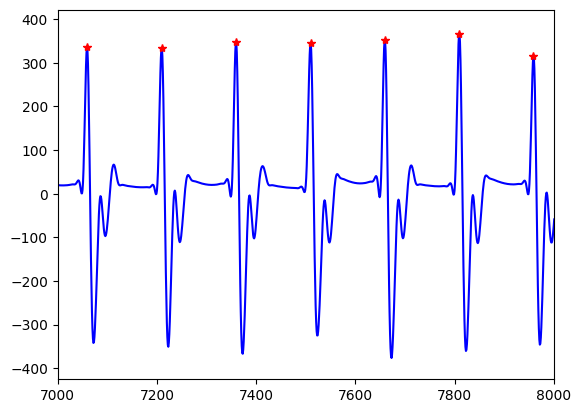

In [19]:
from scipy.signal import find_peaks
plt.plot(nk.ppg_clean(concatenated_list[0], sampling_rate=100),'-b')
plt.xlim(7000,8000)
cleaned_ppg = nk.ppg_clean(concatenated_list[0], sampling_rate=100)
peaks, _ = find_peaks(cleaned_ppg, height=0.2, distance=120)
plt.plot(peaks, cleaned_ppg[peaks],'*r')
#print(peaks)


In [20]:
#now test the model with HRV added to each cardia cycle 
print(len(dtw_rm_addedfeatures))
print(len(dtw_rm_addedfeatures))
X = dtw_rmo
X = [item for sublist in X for item in sublist]

lengths = [len(inner_list) for inner_list in zt_rmo]
y = [[idx] * length for idx, length in enumerate(lengths)]
y = list(chain.from_iterable(y))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = xgb.XGBClassifier(base_score=0.21935381, max_depth= 3, n_estimators= 127,tree_method='gpu_hist', gpu_id=0)

regressor.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_test, y_test)])
y_pred = regressor.predict(X_test)
y_pred=np.round(y_pred)
print(y_pred)
#print(y_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

100
100
[0]	validation_0-mlogloss:0.71564	validation_1-mlogloss:0.91038
[1]	validation_0-mlogloss:0.31785	validation_1-mlogloss:0.46952
[2]	validation_0-mlogloss:0.22070	validation_1-mlogloss:0.36050
[3]	validation_0-mlogloss:0.16089	validation_1-mlogloss:0.28283
[4]	validation_0-mlogloss:0.11959	validation_1-mlogloss:0.22657
[5]	validation_0-mlogloss:0.09031	validation_1-mlogloss:0.18381
[6]	validation_0-mlogloss:0.06913	validation_1-mlogloss:0.15098
[7]	validation_0-mlogloss:0.05338	validation_1-mlogloss:0.12414
[8]	validation_0-mlogloss:0.04186	validation_1-mlogloss:0.10400
[9]	validation_0-mlogloss:0.03327	validation_1-mlogloss:0.08791
[10]	validation_0-mlogloss:0.02685	validation_1-mlogloss:0.07589
[11]	validation_0-mlogloss:0.02193	validation_1-mlogloss:0.06556
[12]	validation_0-mlogloss:0.01821	validation_1-mlogloss:0.05748
[13]	validation_0-mlogloss:0.01540	validation_1-mlogloss:0.05135
[14]	validation_0-mlogloss:0.01325	validation_1-mlogloss:0.04634
[15]	validation_0-mlogloss:

[126]	validation_0-mlogloss:0.00465	validation_1-mlogloss:0.02716
[83 85 63 ... 42 49 58]
Accuracy: 0.9964476021314387


In [21]:
# print other metrics 
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    classification_report
)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print basic metrics
print("Accuracy     :", round(accuracy, 4))
print("Precision    :", round(precision, 4))
print("Recall       :", round(recall, 4))
print("F1 Score     :", round(f1, 4))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# AUC-ROC for multiclass
try:
    y_prob = regressor.predict_proba(X_test)
    classes = np.unique(y_test)
    y_test_binarized = label_binarize(y_test, classes=classes)
    roc_auc = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr', average='macro')
    print("AUC-ROC      :", round(roc_auc, 4))
except Exception as e:
    print("AUC-ROC      : Not available -", e)

# Calculate FAR (False Acceptance Rate) and FRR (False Rejection Rate)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Only proceed if cm.shape == (2, 2)
if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
    FAR = fp / (fp + tn)
    FRR = fn / (fn + tp)
    print("FAR (False Acceptance Rate):", round(FAR, 4))
    print("FRR (False Rejection Rate):", round(FRR, 4))
else:
    print("FAR/FRR calculation skipped: not a binary classification task.")

Accuracy     : 0.9964
Precision    : 0.9966
Recall       : 0.9962
F1 Score     : 0.9963

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        26
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        21
          10       1.00      1.00      1.00        31
          11       1.00      1.00      1.00        27
          12       1.00      1.00      1.00        28
          13       0.95      0.90      0.92        20
          14       1.00      1.00      1.00        21
          15       1.0

In [22]:
# calculate metrics for other classifiers
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import label_binarize

import numpy as np

# Replace these with your actual data
# X = feature matrix, y = labels
# X, y = ...

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Define classifiers
models = {
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(max_depth=15),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

# Evaluation function
def evaluate_model(name, model):
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    try:
        y_prob_bin = label_binarize(y_pred, classes=classes)
        auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr', average='macro')
    except Exception as e:
        auc = None

    print("Accuracy     :", round(accuracy, 4))
    print("Precision    :", round(precision, 4))
    print("Recall       :", round(recall, 4))
    print("F1 Score     :", round(f1, 4))
    print("AUC-ROC      :", round(auc, 4) if auc is not None else "Not available")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Run evaluations
for name, model in models.items():
    evaluate_model(name, model)


--- SVM ---
Accuracy     : 0.5844
Precision    : 0.5793
Recall       : 0.5772
F1 Score     : 0.5568
AUC-ROC      : 0.9845

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.65      0.54        31
           1       0.19      0.38      0.26        16
           2       0.42      0.56      0.48        18
           3       0.40      0.64      0.49        25
           4       0.68      0.48      0.57        27
           5       0.69      0.82      0.75        33
           6       0.65      0.77      0.70        26
           7       0.43      1.00      0.60        16
           8       0.43      0.21      0.29        14
           9       0.30      0.14      0.19        21
          10       0.68      0.42      0.52        31
          11       0.66      0.85      0.74        27
          12       0.43      0.21      0.29        28
          13       0.94      0.85      0.89        20
          14       0.75      0.43      0.

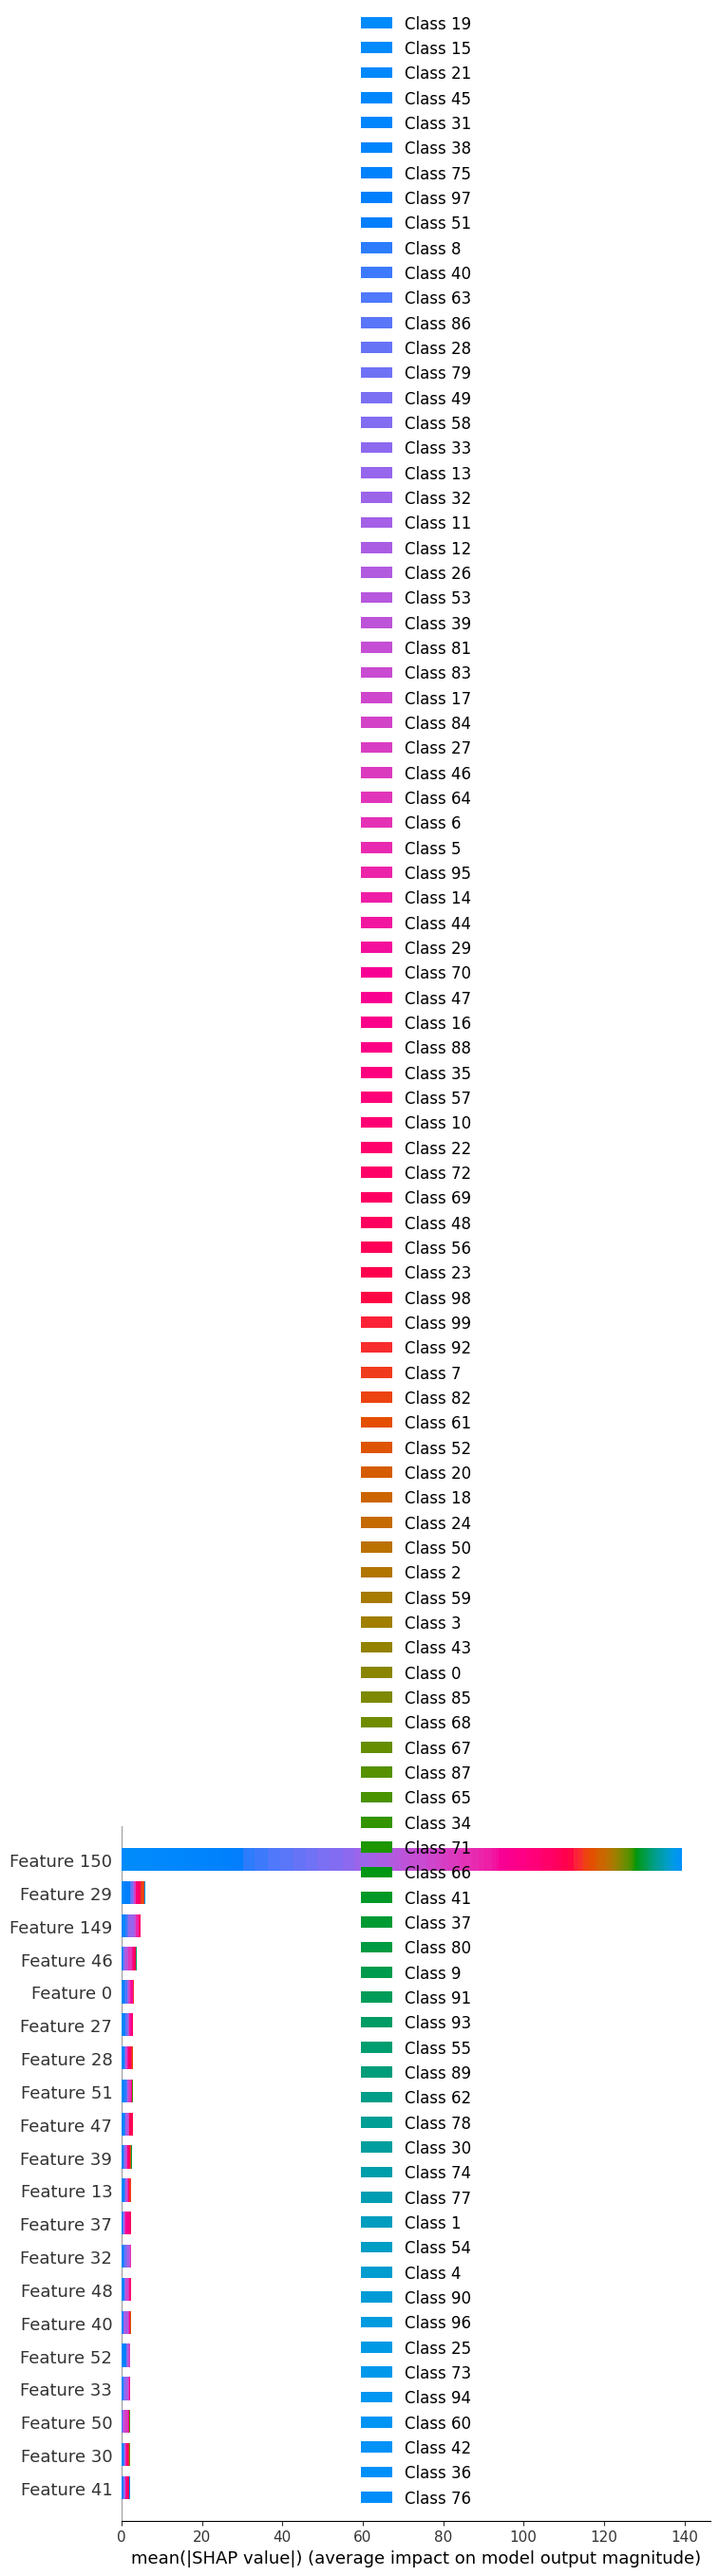

In [314]:
import shap

explainer  = shap.Explainer(regressor)
shap_values = explainer.shap_values(X_test)

#shap.summary_plot(shap_values, X_train)
shap.summary_plot(shap_values)
#shap.force_plot(explainer.expected_value[0], shap_values[0], X_test[0])


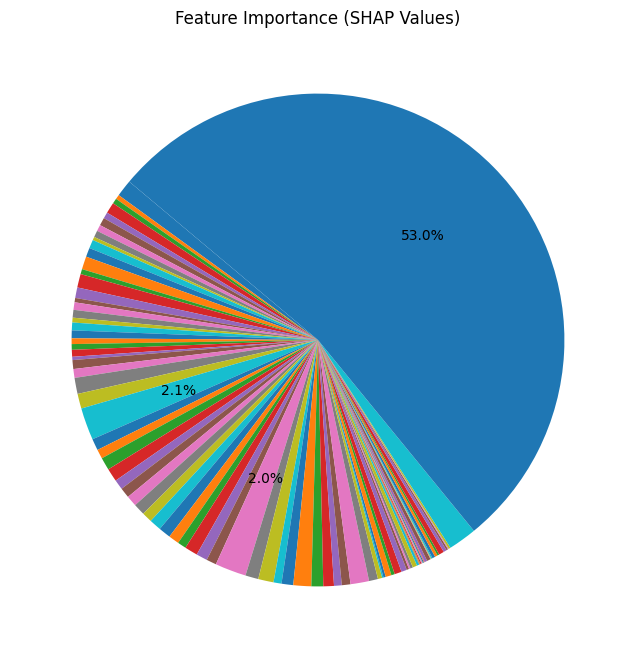

In [230]:
# Sum absolute SHAP values for each feature across all instances
feature_importance = np.abs(shap_values).mean(axis=0)

# Normalize feature importance values to create a pie chart
normalized_importance = feature_importance / feature_importance.sum()
important_features = normalized_importance >= 0.02

feature_labels = [str(i + 1) for i in range(len(normalized_importance))]





# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(normalized_importance[0], autopct=lambda p: '{:.1f}%'.format(p) if p >= 2 else '', startangle=140)
plt.title('Feature Importance (SHAP Values)')
plt.show()
